In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [2]:
# --- Metrics ---
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Read data

In [3]:
df = pd.read_csv("df_final_bh_amazonas.csv")

In [4]:
df.head()

,Date,DayOfWeek,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,IsDayAfterHoliday,temp_max,temp_min,temp_mean,humidity_max,humidity_min,NUMBER_INT,CO,MP10,O3,MP2.5,SO2
0,2015-01-01,Thu,3,1,1,0,1,0,33.9,20.6,25.912500,89.0,32.0,30,0.0,NaN,68.0,NaN,82.0
1,2015-01-02,Fri,4,1,1,0,0,1,32.9,21.0,26.050000,87.0,38.0,43,0.0,NaN,79.0,NaN,83.0
2,2015-01-03,Sat,5,1,1,1,0,0,33.5,20.2,26.683333,83.0,38.0,23,0.0,NaN,44.0,NaN,83.0
3,2015-01-04,Sun,6,1,1,1,0,0,30.6,22.2,25.641667,81.0,43.0,20,0.0,NaN,49.0,NaN,82.0
4,2015-01-05,Mon,0,2,1,0,0,0,30.8,20.8,25.520833,79.0,36.0,51,0.0,NaN,59.0,NaN,82.0


In [5]:
df.count()

Date                 1826
DayOfWeek            1826
DayOfWeekNum         1826
WeekOfYear           1826
Month                1826
IsWeekend            1826
IsHoliday            1826
IsDayAfterHoliday    1826
temp_max             1826
temp_min             1826
temp_mean            1826
humidity_max         1826
humidity_min         1826
NUMBER_INT           1826
CO                   1581
MP10                 1457
O3                   1265
MP2.5                1195
SO2                  1091
dtype: int64

### Set features

In [6]:
selected_cols_final = [
    'Date',
    'DayOfWeekNum',
    'WeekOfYear',
    'Month',
    'IsWeekend',
    'IsHoliday',
    'NUMBER_INT',
    'SO2',
    'temp_max',
    'temp_min',
    'humidity_max',
]

df_final = df[selected_cols_final].copy()

In [7]:
# add lag

df_final['SO2_lag1'] = df_final['SO2'].shift(1)
df_final['SO2_lag2'] = df_final['SO2'].shift(2)
df_final['SO2_lag3'] = df_final['SO2'].shift(3)

df_final['temp_min_lag1'] = df_final['temp_min'].shift(1)
df_final['temp_min_lag2'] = df_final['temp_min'].shift(2)
df_final['temp_min_lag3'] = df_final['temp_min'].shift(3)

# df_final['humidity_max_lag1'] = df_final['humidity_max'].shift(1)
# df_final['humidity_max_lag2'] = df_final['humidity_max'].shift(2)
# df_final['humidity_max_lag3'] = df_final['humidity_max'].shift(3)

In [8]:
df_final = df_final.dropna()

In [9]:
# Check non-null counts and data types
df_final.info()

# Check descriptive statistics
df_final.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
Index: 1031 entries, 3 to 1620
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1031 non-null   object 
 1   DayOfWeekNum   1031 non-null   int64  
 2   WeekOfYear     1031 non-null   int64  
 3   Month          1031 non-null   int64  
 4   IsWeekend      1031 non-null   int64  
 5   IsHoliday      1031 non-null   int64  
 6   NUMBER_INT     1031 non-null   int64  
 7   SO2            1031 non-null   float64
 8   temp_max       1031 non-null   float64
 9   temp_min       1031 non-null   float64
 10  humidity_max   1031 non-null   float64
 11  SO2_lag1       1031 non-null   float64
 12  SO2_lag2       1031 non-null   float64
 13  SO2_lag3       1031 non-null   float64
 14  temp_min_lag1  1031 non-null   float64
 15  temp_min_lag2  1031 non-null   float64
 16  temp_min_lag3  1031 non-null   float64
dtypes: float64(10), int64(6), object(1)
memory usage: 145.0+ 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,1031,1031,2019-06-09,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeekNum,1031.0,NaN,NaN,NaN,2.977692,2.012699,0.0,1.0,3.0,5.0,6.0
WeekOfYear,1031.0,NaN,NaN,NaN,26.685742,16.03177,1.0,13.0,25.0,42.0,53.0
Month,1031.0,NaN,NaN,NaN,6.548012,3.672434,1.0,3.0,6.0,10.0,12.0
IsWeekend,1031.0,NaN,NaN,NaN,0.28516,0.45171,0.0,0.0,0.0,1.0,1.0
IsHoliday,1031.0,NaN,NaN,NaN,0.030068,0.170857,0.0,0.0,0.0,0.0,1.0
NUMBER_INT,1031.0,NaN,NaN,NaN,46.827352,15.882129,11.0,35.0,45.0,58.0,91.0
SO2,1031.0,NaN,NaN,NaN,18.508244,16.759454,0.0,8.0,12.0,24.0,82.0
temp_max,1031.0,NaN,NaN,NaN,28.431814,2.899169,17.8,26.7,28.7,30.5,36.1
temp_min,1031.0,NaN,NaN,NaN,18.095053,2.570725,7.7,16.6,18.7,19.8,23.6


In [10]:
df_final.dtypes

Date              object
DayOfWeekNum       int64
WeekOfYear         int64
Month              int64
IsWeekend          int64
IsHoliday          int64
NUMBER_INT         int64
SO2              float64
temp_max         float64
temp_min         float64
humidity_max     float64
SO2_lag1         float64
SO2_lag2         float64
SO2_lag3         float64
temp_min_lag1    float64
temp_min_lag2    float64
temp_min_lag3    float64
dtype: object

## Train

In [11]:
df_final['Date'] = pd.to_datetime(df_final['Date'])
# df_final = df_final.sort_values(by='Date')

# remove the last 5 days (account for lag ...)
# df_final = df_final[:-5]

# Range for training and testing (4 years for training, 1 year for validation)
min_year = df_final['Date'].dt.year.min()
train_mask = df_final['Date'].dt.year < (min_year + 4)
val_mask = df_final['Date'].dt.year == (min_year + 4)



df_train = df_final[train_mask]
df_val = df_final[val_mask]

df_train = df_train.drop(columns=['Date'])
df_val = df_val.drop(columns=['Date'])

X = df_final.drop(columns=['Date', 'NUMBER_INT'])
y = df_final['NUMBER_INT']


X_train = df_train.drop(columns=['NUMBER_INT'])
y_train = df_train['NUMBER_INT']

X_val = df_val.drop(columns=['NUMBER_INT'])
y_val = df_val['NUMBER_INT']

In [12]:
df_train.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,SO2,temp_max,temp_min,humidity_max,SO2_lag1,SO2_lag2,SO2_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
3,6,1,1,1,0,20,82.0,30.6,22.2,81.0,83.0,83.0,82.0,20.2,21.0,20.6
4,0,2,1,0,0,51,82.0,30.8,20.8,79.0,82.0,83.0,83.0,22.2,20.2,21.0
5,1,2,1,0,0,23,82.0,29.5,20.5,79.0,82.0,82.0,83.0,20.8,22.2,20.2
6,2,2,1,0,0,43,82.0,28.0,19.9,78.0,82.0,82.0,82.0,20.5,20.8,22.2
7,3,2,1,0,0,49,82.0,30.4,19.7,74.0,82.0,82.0,82.0,19.9,20.5,20.8


In [13]:
df_train.tail()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,SO2,temp_max,temp_min,humidity_max,SO2_lag1,SO2_lag2,SO2_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
1456,3,52,12,0,0,60,14.0,24.8,18.8,92.0,14.0,14.0,14.0,18.6,18.5,18.5
1457,4,52,12,0,0,61,14.0,25.4,18.5,92.0,14.0,14.0,14.0,18.8,18.6,18.5
1458,5,52,12,1,0,30,14.0,27.5,17.7,92.0,14.0,14.0,14.0,18.5,18.8,18.6
1459,6,52,12,1,0,26,12.0,27.3,18.5,93.0,14.0,14.0,14.0,17.7,18.5,18.8
1460,0,1,12,0,0,61,14.0,25.9,19.2,92.0,12.0,14.0,14.0,18.5,17.7,18.5


In [14]:
df_val.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,SO2,temp_max,temp_min,humidity_max,SO2_lag1,SO2_lag2,SO2_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
1461,1,1,1,0,1,44,16.0,27.9,19.2,92.0,14.0,12.0,14.0,19.2,18.5,17.7
1462,2,1,1,0,0,45,16.0,31.1,18.9,90.0,16.0,14.0,12.0,19.2,19.2,18.5
1463,3,1,1,0,0,28,16.0,30.7,20.4,88.0,16.0,16.0,14.0,18.9,19.2,19.2
1464,4,1,1,0,0,37,16.0,25.4,19.0,91.0,16.0,16.0,16.0,20.4,18.9,19.2
1465,5,1,1,1,0,36,22.0,30.1,18.6,91.0,16.0,16.0,16.0,19.0,20.4,18.9


In [15]:
df_val.tail()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,SO2,temp_max,temp_min,humidity_max,SO2_lag1,SO2_lag2,SO2_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
1616,2,23,6,0,0,74,10.0,23.2,12.5,75.0,10.0,10.0,14.0,14.2,16.2,15.2
1617,3,23,6,0,0,55,10.0,22.9,12.1,84.0,10.0,10.0,10.0,12.5,14.2,16.2
1618,4,23,6,0,0,64,10.0,24.1,11.2,88.0,10.0,10.0,10.0,12.1,12.5,14.2
1619,5,23,6,1,0,48,10.0,23.6,11.6,86.0,10.0,10.0,10.0,11.2,12.1,12.5
1620,6,23,6,1,0,40,10.0,23.6,11.7,91.0,10.0,10.0,10.0,11.6,11.2,12.1


## Test (10x with cv)

In [16]:
results = []
results30 = []

param_grid = {
    'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160],
    'max_depth': [2, 4, 6, 10, 12, 14, 16, 18, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [17]:
for i in range(10):
    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=i),
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print(f"\nRun {i+1} Best Hyperparameters:")
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Best R-squared: {grid_search.best_score_:.4f}")

    best_xgb_model = grid_search.best_estimator_
    y_pred = best_xgb_model.predict(X_val)

    # Metrics 1y
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    mape_val = mape(y_val, y_pred)
    smape_val = smape(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    corr = np.corrcoef(y_val, y_pred)[0, 1]

    # Metrics 30d
    y_pred_30d = best_xgb_model.predict(X_val[:30])
    y_val_30 = y_val[:30]
    mse_30d = mean_squared_error(y_val_30, y_pred_30d)
    rmse_30d = np.sqrt(mse_30d)
    mae_30d = mean_absolute_error(y_val_30, y_pred_30d)
    mape_val_30d = mape(y_val_30, y_pred_30d)
    smape_val_30d = smape(y_val_30, y_pred_30d)
    r2_30d = r2_score(y_val_30, y_pred_30d)
    corr_30d = np.corrcoef(y_val_30, y_pred_30d)[0, 1]

    results.append({
        'run': i+1,
        'random_state': i,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape_val,
        'sMAPE': smape_val,
        'R2': r2,
        'Correlation': corr,
        'Best Params': grid_search.best_params_,
        'Best Cross-validated R-squared': grid_search.best_score_
    })

    results30.append({
        'run': i+1,
        'random_state': i,
        'MSE_30d': mse_30d,
        'RMSE_30d': rmse_30d,
        'MAE_30d': mae_30d,
        'MAPE_30d': mape_val_30d,
        'sMAPE_30d': smape_val_30d,
        'R2_30d': r2_30d,
        'Correlation_30d': corr_30d
    })




Run 1 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 80, 'subsample': 0.9}
Best R-squared: 0.5097

Run 2 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}
Best R-squared: 0.5196

Run 3 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 40, 'subsample': 1.0}
Best R-squared: 0.5071

Run 4 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}
Best R-squared: 0.5157

Run 5 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 80, 'subsample': 0.9}
Best R-squared: 0.5062

Run 6 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_

### Results 1y

In [18]:
results_df = pd.DataFrame(results)
results_df

,run,random_state,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation,Best Params,Best Cross-validated R-squared
0,1,0,115.298355,10.737707,8.449480,15.997744,17.331348,0.566811,0.833604,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.509667
1,2,1,112.621941,10.612348,8.280960,15.911287,17.215327,0.576867,0.833926,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.519642
2,3,2,107.995178,10.392073,8.121269,15.397879,16.507125,0.594250,0.843496,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.507113
3,4,3,111.737907,10.570615,8.271641,15.869544,17.099114,0.580188,0.835227,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.515730
4,5,4,108.855904,10.433403,8.140143,15.725164,16.741861,0.591016,0.833453,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.506155
5,6,5,109.079445,10.444111,8.198237,15.658337,16.851260,0.590177,0.838875,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.508379
6,7,6,109.425583,10.460668,8.282873,15.805819,16.891672,0.588876,0.839981,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.508186
7,8,7,104.543861,10.224669,7.993565,15.409477,16.361927,0.607217,0.838616,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.515926
8,9,8,112.971970,10.628827,8.466542,16.429674,17.749217,0.575552,0.836094,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.524754
9,10,9,114.444939,10.697894,8.406010,16.313327,17.763547,0.570018,0.834051,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.511521


In [19]:
results_df.describe()

,run,random_state,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation,Best Cross-validated R-squared
count,10.00000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,4.50000,110.697508,10.520232,8.261072,15.851825,17.051240,0.584097,0.836732,0.512707
std,3.02765,3.02765,3.299284,0.157176,0.152528,0.338193,0.475466,0.012396,0.003378,0.006117
min,1.00000,0.00000,104.543861,10.224669,7.993565,15.397879,16.361927,0.566811,0.833453,0.506155
25%,3.25000,2.25000,108.911789,10.436080,8.154667,15.675043,16.769211,0.575881,0.833957,0.508234
50%,5.50000,4.50000,110.581745,10.515642,8.276300,15.837681,16.995393,0.584532,0.835660,0.510594
75%,7.75000,6.75000,112.884462,10.624708,8.375226,15.976130,17.302343,0.590806,0.838811,0.515877
max,10.00000,9.00000,115.298355,10.737707,8.466542,16.429674,17.763547,0.607217,0.843496,0.524754


### results 30d

In [20]:
results_df_30 = pd.DataFrame(results30)
results_df_30

,run,random_state,MSE_30d,RMSE_30d,MAE_30d,MAPE_30d,sMAPE_30d,R2_30d,Correlation_30d
0,1,0,56.359562,7.507301,6.073165,15.215324,16.405522,0.158268,0.673080
1,2,1,58.243759,7.631760,6.529620,17.062051,18.420808,0.130128,0.693023
2,3,2,55.649532,7.459861,6.207150,15.803489,16.794207,0.168872,0.657909
3,4,3,66.270660,8.140679,6.621041,16.649721,18.185964,0.010246,0.638507
4,5,4,60.469864,7.776237,6.278387,15.481059,16.698310,0.096881,0.636622
5,6,5,65.461617,8.090835,6.732720,16.990418,18.558597,0.022329,0.652168
6,7,6,56.326458,7.505095,6.419610,16.633490,17.818730,0.158763,0.688809
7,8,7,55.133186,7.425172,6.141798,15.595651,16.633133,0.176584,0.658216
8,9,8,72.964195,8.541908,7.444737,19.298977,21.312845,-0.089723,0.661946
9,10,9,69.168259,8.316746,7.130785,18.739472,20.749450,-0.033030,0.679366


In [21]:
results_df_30.describe()

,run,random_state,MSE_30d,RMSE_30d,MAE_30d,MAPE_30d,sMAPE_30d,R2_30d,Correlation_30d
count,10.00000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,4.50000,61.604709,7.839560,6.557901,16.746965,18.157756,0.079932,0.663965
std,3.02765,3.02765,6.396111,0.402789,0.444524,1.367392,1.712734,0.095526,0.019410
min,1.00000,0.00000,55.133186,7.425172,6.073165,15.215324,16.405522,-0.089723,0.636622
25%,3.25000,2.25000,56.334734,7.505647,6.224959,15.647610,16.722284,0.013266,0.653603
50%,5.50000,4.50000,59.356812,7.703999,6.474615,16.641605,18.002347,0.113504,0.660081
75%,7.75000,6.75000,66.068399,8.128218,6.704800,17.044143,18.524150,0.158639,0.677795
max,10.00000,9.00000,72.964195,8.541908,7.444737,19.298977,21.312845,0.176584,0.693023


## Plots    

In [22]:
best_idx = results_df['RMSE'].idxmin()
print(f"Best run based on RMSE: Run {results_df.loc[best_idx, 'run']} with RMSE = {results_df.loc[best_idx, 'RMSE']:.2f}")

best_params = results_df.loc[best_idx, 'Best Params']
print(f"Best parameters: {best_params}")

best_random_state = results_df.loc[best_idx, 'run'] - 1 

# Rebuild the best model
best_model = XGBRegressor(random_state=best_random_state, **best_params)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_val)


Best run based on RMSE: Run 8 with RMSE = 10.22
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 60, 'subsample': 0.9}


### 1y

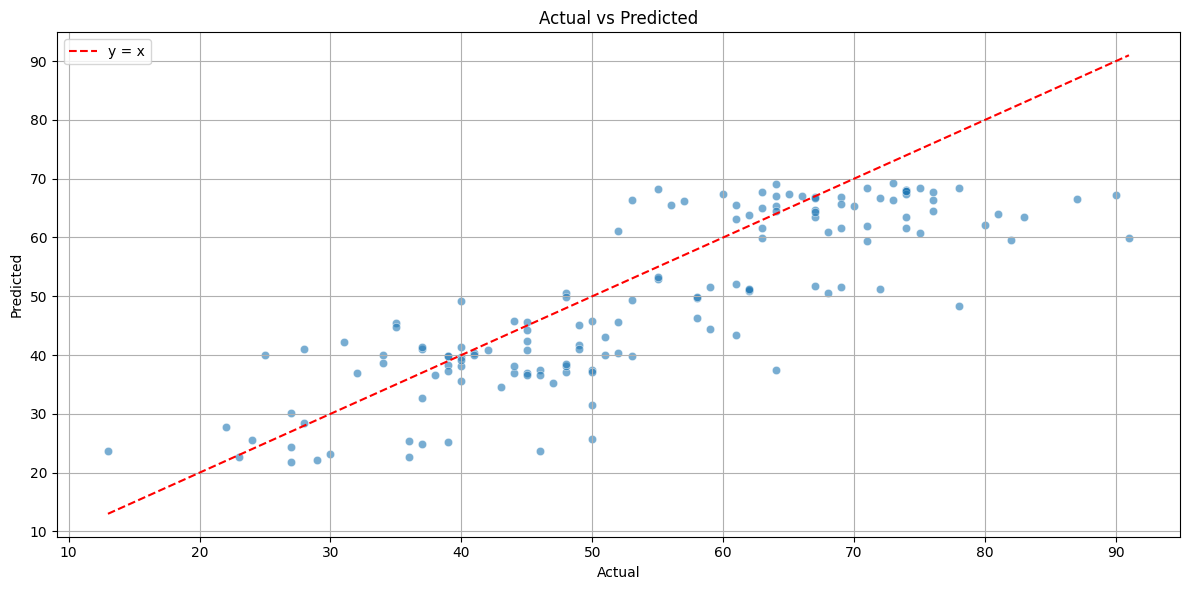

In [23]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:], y=y_pred_best, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

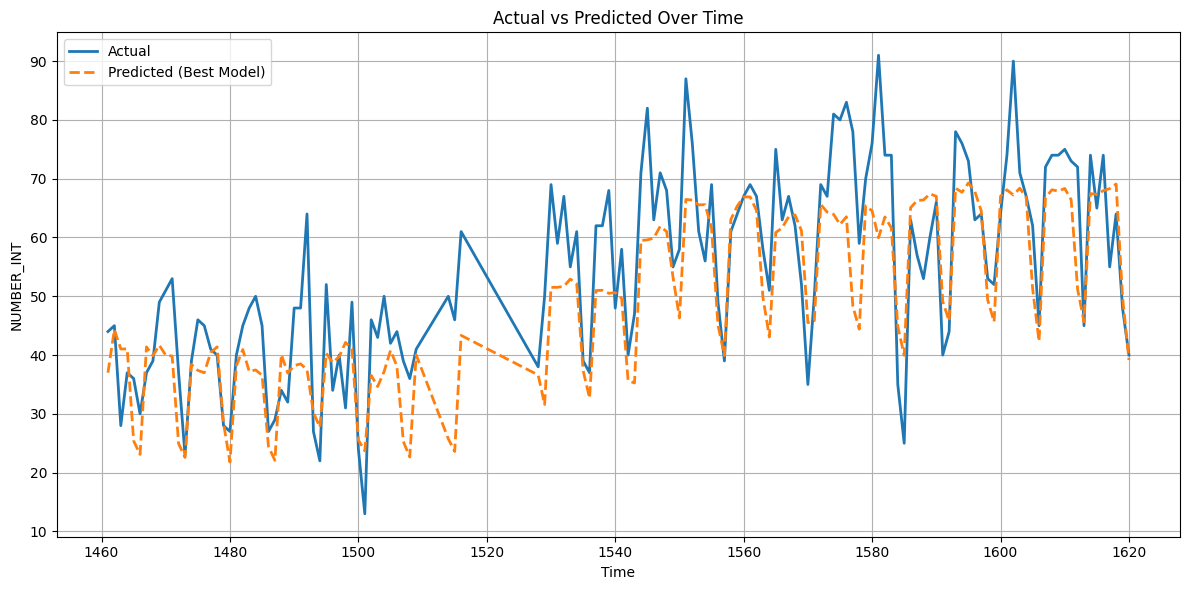

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
plt.plot(y_val.index, y_pred_best, label='Predicted (Best Model)', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title(f'Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 30d

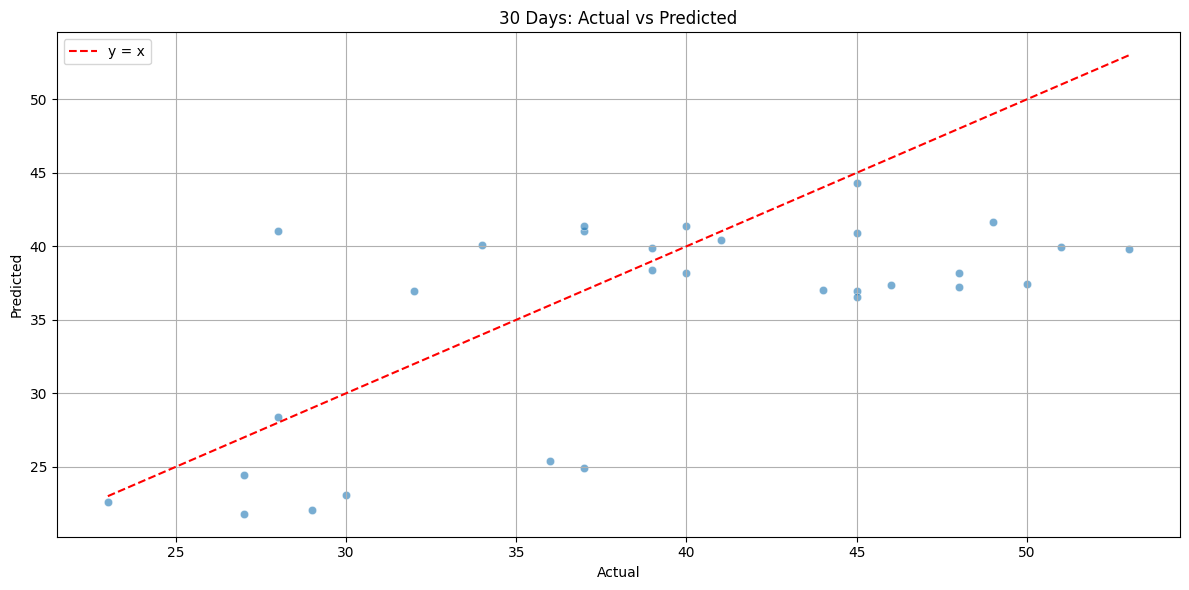

In [25]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:30], y=y_pred_best[:30], alpha=0.6)
plt.plot([y_val[:30].min(), y_val[:30].max()], [y_val[:30].min(), y_val[:30].max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('30 Days: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


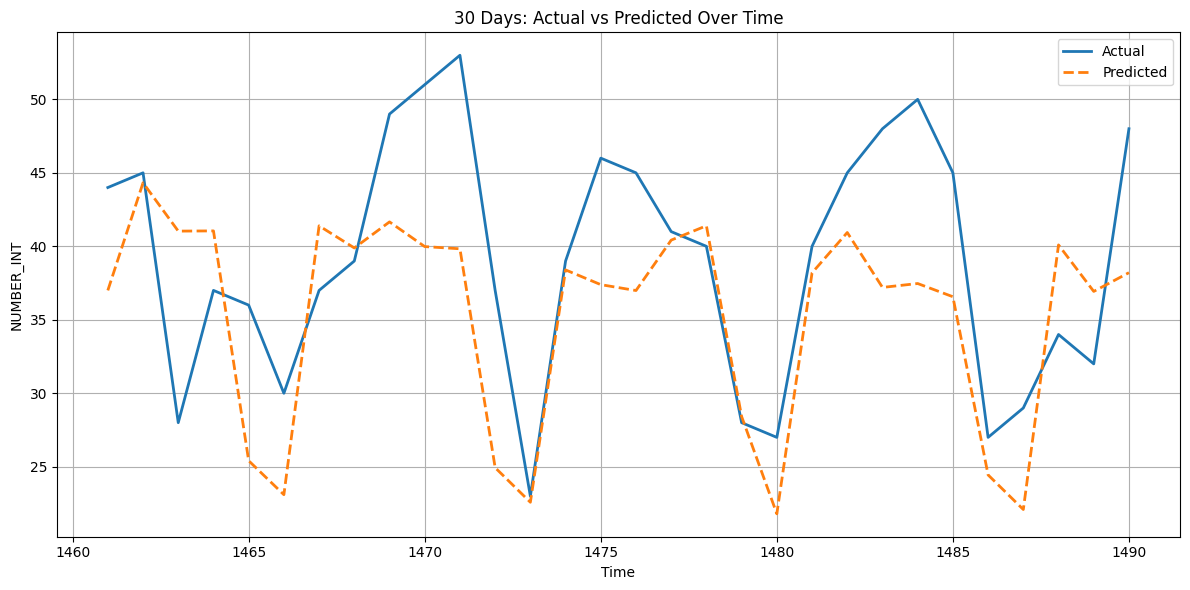

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index[:30], y_val[:30].values, label='Actual', linewidth=2)
plt.plot(y_val.index[:30], y_pred_best[:30], label='Predicted', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title('30 Days: Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

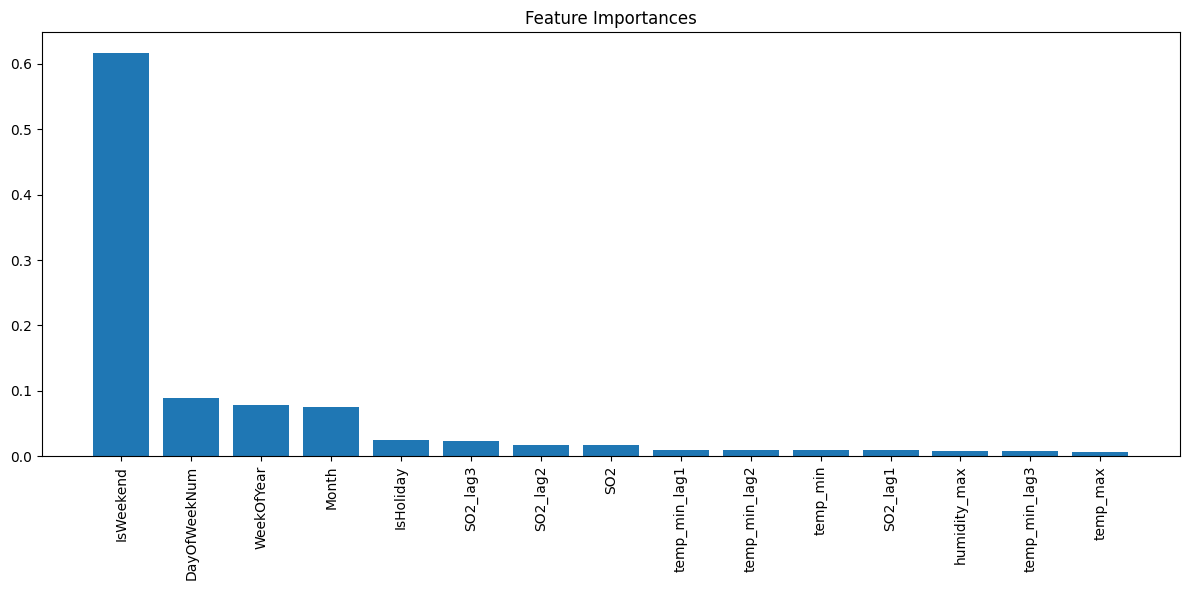

In [27]:
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()